In [71]:
#importing 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange
from tqdm import tqdm


In [72]:
#importing the dataset using tinygrad
from tinygrad.nn.datasets import mnist
#mnist() returns four tensors
X_train, Y_train, X_test, Y_test = mnist()
#converting into numpy
X_train = X_train.reshape(-1, 784).numpy().astype(np.float32)
Y_train = Y_train.numpy().astype(np.int8)
X_test = X_test.reshape(-1, 784).numpy().astype(np.float64)
Y_test = Y_test.numpy().astype(np.int8)
print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)

(60000, 784) float32 (60000,) int8


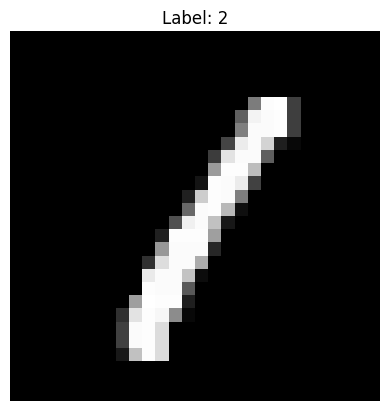

In [73]:
from matplotlib import pyplot as plt

def imshow(image, label):
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

imshow(X_train[3].astype(float), int(Y_train[5].item()))

In [74]:
#initializing the model
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        self.sm = nn.LogSoftmax(dim=None)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x
        

In [75]:
from tqdm import tqdm
#aining the model
model = CNet()
lossfunction = nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
epochs = 1000
#list to store the accuracies and losses will later plot it
losses = []
accuracies = []
# Uing tqdm's trange for the progress bar
progress_bar = tqdm(total=epochs, desc='Training Progress')
for i in trange(epochs):
    sample = np.random.randint(0,X_train.shape[0],size=(BS))

    #converting into pytorch tensors
    X = torch.tensor(X_train[sample].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[sample]).long()

    #making the gradient zero
    optimizer.zero_grad() 
    
    out = model(X)

    #calculating the accuracy
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()

    
    loss = lossfunction(out, Y)
    loss = loss.mean()
    loss.backward()

    
    optimizer.step()
    
    # loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    # to show the epochs : tqdm.write(f'Epoch [{i+1}/{epochs}], Loss: {loss.item():.2f}, Accuracy: {accuracy:.2f}')
    progress_bar.set_description(f'Loss: {loss:.2f}, Accuracy: {accuracy:.2f}')




Loss: 0.18, Accuracy: 0.95:   0%|          | 0/1000 [21:07:01<?, ?it/s]
/Users/chiragtaneja/Documents/ML/neural networks/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 1000/1000 [00:01<00:00, 605.41it/s][00:01<?, ?it/s] 


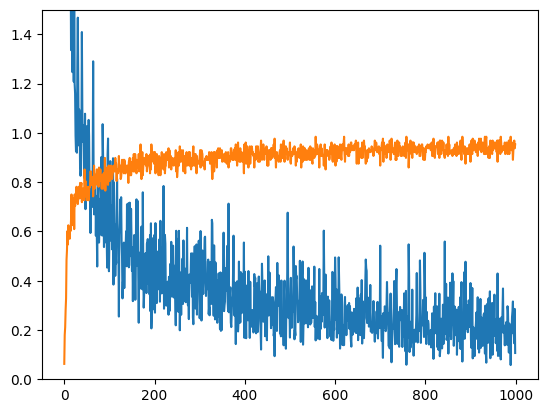

In [76]:
#plotting the graph 
from matplotlib.pyplot import plot
losses_tensor = torch.tensor(losses)
accuracies_tensor = torch.tensor(accuracies)

plt.ylim(0, 1.5)
plot(losses_tensor.detach().numpy())
plot(accuracies_tensor.detach().numpy())

# you can see the loss is decreasing then the accuracy is increasing

In [77]:
# accuracy of the pytorch model
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
accuracy  = (Y_test == Y_test_preds).mean()
print(f"test set accuracy is {accuracy}")

test set accuracy is 0.9323


### checking the model with numpy

In [78]:
#we will copy the weights from the pytorch nn
w1 = model.l1.weight.detach().numpy().T #.astype(np.float64)
w2 = model.l2.weight.detach().numpy().T #.astype(np.float64)

In [79]:
# we will do forward pass using numpy
# in this model we have not used bias so we are doing it with weights only
def forward(x):
    x = x.reshape(-1, 784) #Reshape the input x to have 784 features
    x = x.dot(w1)# Perform matrix multiplication between x and w1 (first layer weights)
    x = np.maximum(0,x)#Apply the ReLU activation function element-wise
    x = x.dot(w2) # Perform matrix multiplication between the activated output and w2 (second layer weights)
    return x

In [80]:
#we will check the sanity of the model with numpy
def np_eval():
    pred = forward(X_test).argmax(axis=1)
    accuracy1 = (pred == Y_test).mean()
    print(f"test set accuracy is {accuracy1}")

np_eval()

test set accuracy is 0.9323


### solving with numpy

In [81]:
from matplotlib.pyplot import figure
def logsumexp(x):
    c = x.max(axis=1, keepdims=True)
    return c + np.log(np.sum(np.exp(x - c), axis=1, keepdims=True))


# forward and backward pass in numpy
def forward_and_backward(x,y):
    #creates a one-hot encoding array for the given labels
    out = np.zeros((len(y),10), np.float32)
    out[range(out.shape[0]),y] = 1

    #forward pass
    x1 = x @ w1  
    x2 = np.maximum(0,x1)
    x3 = x2 @ w2  
    x_lsm = x3 - logsumexp(x3)
    x_loss = -np.mean(np.sum(out * x_lsm, axis=1))


    # backword pass
    d_out = -out / len(y)
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))
    # derivative of l2
    d_w2 = x2.T @ dx_lsm
    #he gradient of the loss with respect to the ReLU output
    dx_relu = dx_lsm @ w2.T
    '''the gradient of the loss with respect to the first layer output, considering the ReLU activation. The (x_relu > 0) part creates a 
     mask that's 1 where the input was positive (and thus where the ReLU was linear) and 0 elsewhere.'''
    dx_l1 = (x2 > 0).astype(np.float32) * dx_relu
    #gradient of the loss with respect to the weights of the first layer
    d_w1 = x.T @ dx_l1

    return x_loss, x3, d_w1, d_w2



loss 0.12 accuracy 0.97: 100%|██████████| 1000/1000 [00:01<00:00, 557.28it/s]


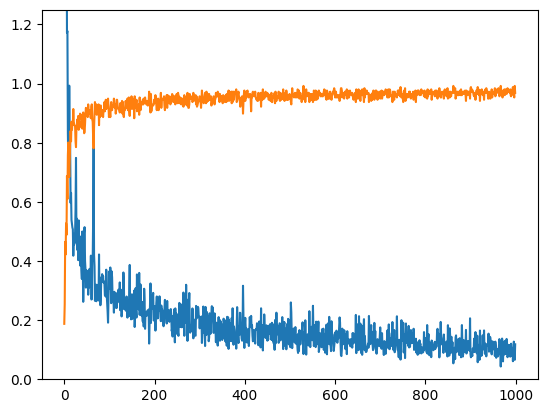

In [88]:
# numpy training
def layer_init(m, h):
  # gaussian is strong
  #ret = np.random.randn(m,h)/np.sqrt(m*h)
  # uniform is stronger
  ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
  return ret.astype(np.float32)


np.random.seed(1337)
w1 = layer_init(784, 128)
w2 = layer_init(128, 10)

lr = 0.001
BS = 256
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = X_train[samp].reshape((-1, 28*28))
  Y = Y_train[samp]
  x_loss, x3, d_w1, d_w2 = forward_and_backward(X, Y)
  
  cat = np.argmax(x3, axis=1)
  accuracy = (cat == Y).mean()
  
  # implementing simple gradient descent or updating the parameters
  w1 = w1 - lr*d_w1
  w2 = w2 - lr*d_w2
  
  loss = x_loss.mean()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(0, 1.25)
plot(losses)
plot(accuracies)

In [89]:
# calculating the accuracy
#we got better accuracy than pytorch
np_eval()

test set accuracy is 0.9649
